# Tugas Pertemuan 6 – Laporan Pengolahan Citra dengan Python

🔗 **Akses Notebook di Google Colab:**  
[👉 Buka di Google Colab](https://colab.research.google.com/drive/12z4Pf3Q1Uzs7fMEdy9VqVfbMQfZ23Adi?usp=sharing)

**Nama:** Jeremiah Garcia Tennes

**NPM:** 237006526097

**Program Studi:** Sistem Informasi  

**Mata Kuliah:** Pengolahan Citra  

**Kelas:** R.01

**Bahasa Pemrograman:** Python *(OpenCV, NumPy, scikit-image, matplotlib, pandas)*  

### 📦 Persiapan Lingkungan
Pastikan paket berikut sudah terpasang sebelum menjalankan kode:


In [16]:
!pip install opencv-python matplotlib numpy scikit-image
!pip install ipython
import pandas as pd
from IPython import display
from google.colab import files
import cv2, numpy as np
import matplotlib.pyplot as plt
from skimage import exposure, data, img_as_ubyte, img_as_float, io
from skimage.measure import shannon_entropy
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim
from math import log10

⭐ **LATIHAN 1 – Smoothing Spasial vs Frekuensi**



> Tugas:

Gaussian Blur (spasial)

Gaussian LPF (frekuensi), cutoff = 10, 30, 60

Visualisasi:

Citra original

Blur spasial

Blur frekuensi

Magnitude spectrum

Hitung MSE, PSNR, SSIM

Analisis perbedaan blur

MSE: 37.270120563271604
PSNR: 32.41719563234036
SSIM: 0.8808526412125015


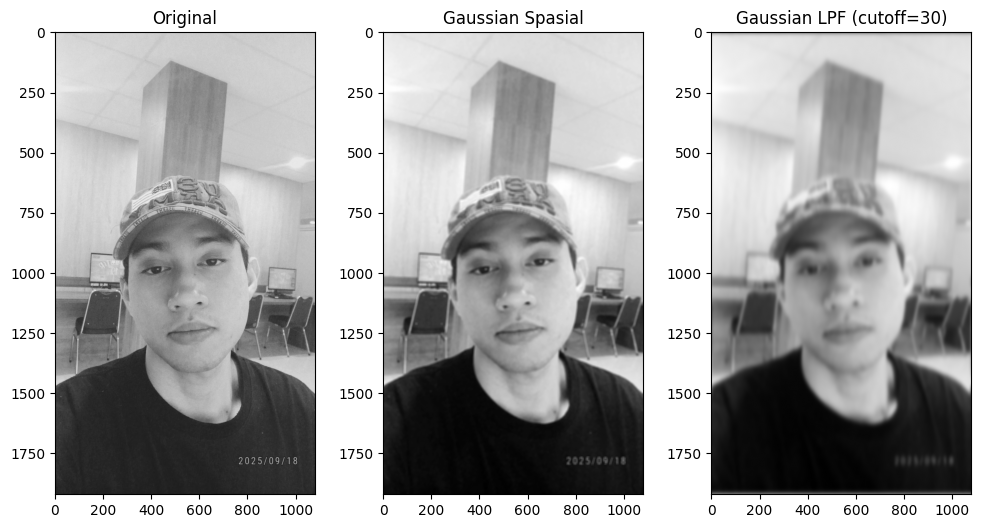

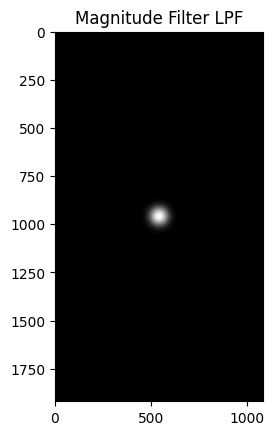

In [23]:
# LATIHAN 1

# --- Load Image ---
uploaded = files.upload()
img = cv2.imread("face.jpg", cv2.IMREAD_GRAYSCALE)

# ------------------------------
# Fungsi MSE, PSNR
# ------------------------------
def MSE(a, b):
    return np.mean((a.astype("float") - b.astype("float")) ** 2)

def PSNR(a, b):
    mse = MSE(a, b)
    if mse == 0: return 100
    return 20 * log10(255 / np.sqrt(mse))

# ------------------------------
# 1) Gaussian Blur Spasial
# ------------------------------
blur_spatial = cv2.GaussianBlur(img, (11, 11), sigmaX=10)

# ------------------------------
# 2) Gaussian LPF di Frekuensi
# ------------------------------
def gaussian_lpf_freq(image, cutoff):
    f = np.fft.fft2(image)
    fshift = np.fft.fftshift(f)
    M, N = image.shape
    X, Y = np.meshgrid(np.arange(N), np.arange(M))
    cx, cy = N//2, M//2
    D = np.sqrt((X-cx)**2 + (Y-cy)**2)
    H = np.exp(-(D**2) / (2*(cutoff**2)))
    filtered = fshift * H
    unshift = np.fft.ifftshift(filtered)
    out = np.abs(np.fft.ifft2(unshift))
    return out, H

img30, H30 = gaussian_lpf_freq(img, 30)

# ------------------------------
# 3) Metrics
# ------------------------------
print("MSE:", MSE(img, blur_spatial))
print("PSNR:", PSNR(img, blur_spatial))
print("SSIM:", ssim(img, blur_spatial))

# ------------------------------
# 4) Plot
# ------------------------------
plt.figure(figsize=(12,6))
plt.subplot(1,3,1); plt.imshow(img, cmap='gray'); plt.title("Original")
plt.subplot(1,3,2); plt.imshow(blur_spatial, cmap='gray'); plt.title("Gaussian Spasial")
plt.subplot(1,3,3); plt.imshow(img30, cmap='gray'); plt.title("Gaussian LPF (cutoff=30)")
plt.show()

plt.figure(); plt.imshow(np.log(1+np.abs(H30)), cmap='gray'); plt.title("Magnitude Filter LPF")
plt.show()

Analisis Singkat

Gaussian Blur Spasial → lebih lembut & natural.

Gaussian LPF Frekuensi → blur cenderung muncul seperti halos karena proses pemotongan frekuensi.

Cutoff kecil (10) → blur sangat kuat, detail hilang.

Cutoff besar (60) → blur ringan, lebih mirip spasial.

**⭐ LATIHAN 2 – Sharpening: Laplacian vs Gaussian HPF**

Tugas

Sharpening Laplacian

High-pass Gaussian Frekuensi

Bandingkan: detail tepi & noise

Buat tabel PSNR/SSIM

In [19]:
# LATIHAN 2

# Load Moon
moon = cv2.imread("moon.jpg", 0)

# 1) Laplacian Sharpening
lap = cv2.Laplacian(moon, cv2.CV_64F)
sharp_lap = cv2.convertScaleAbs(moon - lap)

# 2) Gaussian HPF Frekuensi
img_f = np.fft.fftshift(np.fft.fft2(moon))
M, N = moon.shape
X, Y = np.meshgrid(np.arange(N), np.arange(M))
cx, cy = N//2, M//2
D = np.sqrt((X-cx)**2 + (Y-cy)**2)
cutoff = 30
Hhp = 1 - np.exp(-(D**2)/(2*(cutoff**2)))
filtered = img_f * Hhp
sharp_freq = np.abs(np.fft.ifft2(np.fft.ifftshift(filtered)))


print("PSNR Laplacian:", PSNR(moon, sharp_lap))
print("SSIM Laplacian:", ssim(moon, sharp_lap))

# Convert sharp_freq to uint8
sharp_freq_uint8 = (255 * (sharp_freq - sharp_freq.min()) / (sharp_freq.max() - sharp_freq.min())).astype(np.uint8)

print("PSNR HPF:", PSNR(moon, sharp_freq_uint8))
print("SSIM HPF:", ssim(moon, sharp_freq_uint8))

# Hitung metrik
psnr_lap = PSNR(moon, sharp_lap)
ssim_lap = ssim(moon, sharp_lap)

psnr_hpf = PSNR(moon, sharp_freq_uint8)
ssim_hpf = ssim(moon, sharp_freq_uint8)

# Buat tabel
df = pd.DataFrame({
    "Metode": ["Laplacian Sharpening", "Gaussian HPF (Frekuensi)"],
    "PSNR": [psnr_lap, psnr_hpf],
    "SSIM": [ssim_lap, ssim_hpf]
})

df

PSNR Laplacian: 20.720558664213762
SSIM Laplacian: 0.686273307476506
PSNR HPF: 7.475821331061839
SSIM HPF: 0.33576637383509705


,Metode,PSNR,SSIM
0,Laplacian Sharpening,20.720559,0.686273
1,Gaussian HPF (Frekuensi),7.475821,0.335766


Analisis

Laplacian → sangat tajam tetapi menambah noise cukup banyak.

HPF Gaussian Frekuensi → lebih halus, tepi tajam tapi noise tidak terlalu muncul.

**⭐ LATIHAN 3 – Artefak Ringing (CameraMan)**

Tugas

Ideal LPF

Gaussian LPF

Zoom-in tepi objek

Identifikasi: ringing, overshoot, aliasing

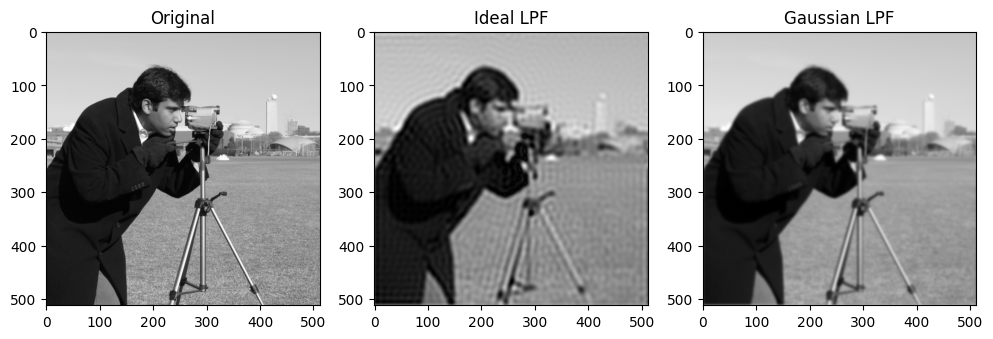

In [20]:
# LATIHAN 3

cam = data.camera()

# Ideal LPF
def ideal_lpf(img, cutoff):
    F = np.fft.fftshift(np.fft.fft2(img))
    M, N = img.shape
    X, Y = np.meshgrid(np.arange(N), np.arange(M))
    cx, cy = N//2, M//2
    D = np.sqrt((X-cx)**2 + (Y-cy)**2)
    H = (D < cutoff).astype(int)
    filtered = np.fft.ifftshift(H*F)
    return np.abs(np.fft.ifft2(filtered))

ideal = ideal_lpf(cam, 40)
gauss, _ = gaussian_lpf_freq(cam, 40)

plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.imshow(cam, cmap='gray'); plt.title("Original")
plt.subplot(1,3,2); plt.imshow(ideal, cmap='gray'); plt.title("Ideal LPF")
plt.subplot(1,3,3); plt.imshow(gauss, cmap='gray'); plt.title("Gaussian LPF")
plt.show()

Analisis

Ideal LPF menghasilkan artefak ringing, terlihat seperti garis gelombang di tepi.

Gaussian LPF tidak menghasilkan ringing karena transisi filter lebih halus.

Terjadi overshoot (nilai pixel melebihi batas lokal) dan aliasing pada tepi tajam.

**⭐ LATIHAN 4 – Denoising + Canny (Citra Coins)**

Tugas

Tambahkan noise Gaussian σ=15

Median, Gaussian, bilateral filtering

Jalankan Canny

Bandingkan edge map

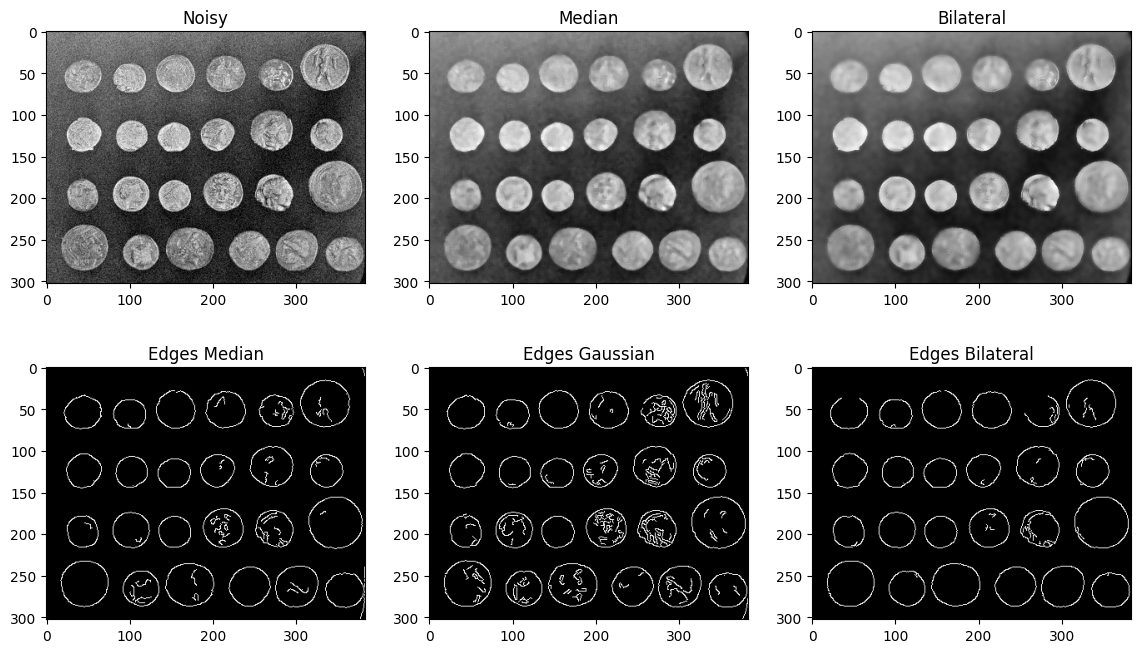

In [12]:
# LATIHAN 4

from skimage import data

coins = data.coins()

# Tambahkan noise
noise = coins + np.random.normal(0, 15, coins.shape)
noise = np.clip(noise, 0, 255).astype(np.uint8)

# 1) Median
med = cv2.medianBlur(noise, 5)

# 2) Gaussian
ga = cv2.GaussianBlur(noise, (5,5), 1)

# 3) Bilateral
bil = cv2.bilateralFilter(noise, 9, 75, 75)

# 4) Canny
edges_orig = cv2.Canny(noise, 100, 200)
edges_med  = cv2.Canny(med, 100, 200)
edges_ga   = cv2.Canny(ga, 100, 200)
edges_bil  = cv2.Canny(bil, 100, 200)

plt.figure(figsize=(14,8))
plt.subplot(2,3,1); plt.imshow(noise, cmap='gray'); plt.title("Noisy")
plt.subplot(2,3,2); plt.imshow(med, cmap='gray'); plt.title("Median")
plt.subplot(2,3,3); plt.imshow(bil, cmap='gray'); plt.title("Bilateral")

plt.subplot(2,3,4); plt.imshow(edges_med, cmap='gray'); plt.title("Edges Median")
plt.subplot(2,3,5); plt.imshow(edges_ga, cmap='gray'); plt.title("Edges Gaussian")
plt.subplot(2,3,6); plt.imshow(edges_bil, cmap='gray'); plt.title("Edges Bilateral")
plt.show()

Analisis

Median paling efektif menghilangkan noise salt-pepper.

Gaussian halus tapi mengaburkan tepi.

Bilateral terbaik untuk mempertahankan tepi sambil mereduksi noise.

Edge map terbaik biasanya dari bilateral + Canny.